Notebook to develop calculations for barotropic to baroclinic conversion,

$ C = <p'(-H) \vec{U}\cdot\nabla H>$

where $p'$ is pressure perturbation, $\vec{U}$ is barotropic velocity, $H$ is bottom topography. So bottom depth is z = -H(x,y)

$ p' = \int_z^0 N^2\zeta dz' - \frac{1}{H} \int_{-H}^0 \int_z^0 N^2\zeta dz' dz$

and $\zeta$ is isopycncal displacement. $<>$ denote an average over a tidal period. See Carter et al (2008), Energetics of M2 Barotropic to Baroclinic Tidal Conversion at the Hawaiian Islands

Alternatively, Kelly et al 2010 Internal‐tide energy over topography, defines

$ p' = p(x,z) - P(x)$

where $p(x,z)$ is the total pressure and $P(x)$ is the depth-averaged pressure.

$P(x) = \frac{1}{H}\int_{-H}^0 p(x,z)dz $

This is bizarre to me because were it the time dependency? I guess, in the model, the depth levels are actually changing with time, so both $z$ and $dz$ are time dependent. 

I will use the Kelly et al 2010 apporach. Note, Kelly warns of using $C_S$ as a correction in shallow areas.

In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt

from nowcast import analyze
from salishsea_tools import viz_tools

import gsw

%matplotlib inline

In [2]:
mesh_mask = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/mesh_mask_SalishSea2.nc')
grid = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')

bathy = grid.variables['Bathymetry'][:]

# 1. Calculate bathymetry gradient

In [3]:
def bathymetry_gradient(bathy, mesh):
    e1t = mesh.variables['e1t'][0,:,:]
    e2t = mesh.variables['e2t'][0,:,:]
    
    diff_x = bathy[:,1:] - bathy[:,:-1]
    diff_y = bathy[1:,:] - bathy[:-1.:]
    diff_x = np.concatenate([np.zeros((bathy.shape[0],1)), diff_x], axis=1) #pad with zeros in first row
    diff_y = np.concatenate([np.zeros((1, bathy.shape[1])), diff_y], axis=0) # pad with zeros in first column
    
    hx = diff_x/e1t
    hy = diff_y/e2t
    
    return hx, hy

In [4]:
hx, hy = bathymetry_gradient(bathy, mesh_mask)

/home/nsoontie/anaconda3/envs/analysis/lib/python3.5/site-packages/numpy/ma/core.py:3114: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dout = self.data[indx]
/home/nsoontie/anaconda3/envs/analysis/lib/python3.5/site-packages/numpy/ma/core.py:3169: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dout._mask = _mask[indx]


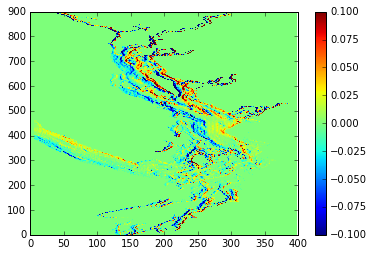

In [5]:
plt.pcolormesh(-hx,vmin=-.1,vmax=.1)
plt.colorbar()

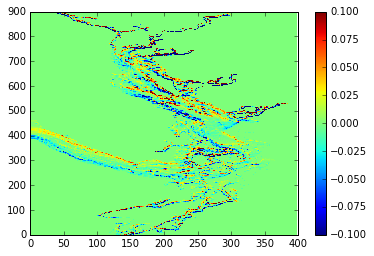

In [6]:
plt.pcolormesh(-hy,vmin=-.1,vmax=.1)
plt.colorbar()

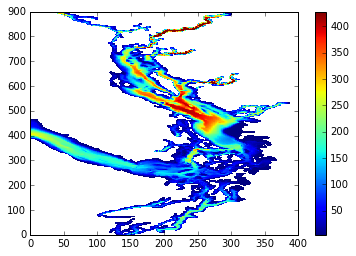

In [7]:
plt.pcolormesh(bathy)
plt.colorbar()

Check that barortopic w makes sense

In [8]:
fU = nc.Dataset('/results/SalishSea/nowcast/01apr15/SalishSea_1h_20150401_20150401_grid_U.nc')
fV = nc.Dataset('/results/SalishSea/nowcast/01apr15/SalishSea_1h_20150401_20150401_grid_V.nc')
fT = nc.Dataset('/results/SalishSea/nowcast/01apr15/SalishSea_1h_20150401_20150401_grid_T.nc')
u = fU.variables['vozocrtx'][:]
v = fV.variables['vomecrty'][:]
ssh = fT.variables['sossheig']
umask = mesh_mask.variables['umask'][:] + np.zeros(u.shape)
vmask = mesh_mask.variables['vmask'][:] + np.zeros(v.shape)
tmask = mesh_mask.variables['tmask'][:]
e3t = mesh_mask.variables['e3t'][:]
e3u = mesh_mask.variables['e3u'][:]
e3v = mesh_mask.variables['e3v'][:]

u_depav = analyze.depth_average_mask(u,e3u[0,:,:,:], umask[0,:,:,:], depth_axis=1)
v_depav = analyze.depth_average_mask(v,e3v[0,:,:,:], vmask[0,:,:,:], depth_axis=1)

udepav_m = np.ma.masked_array(u_depav, mask = 1-umask[:,0,:,:])
vdepav_m = np.ma.masked_array(v_depav, mask = 1-vmask[:,0,:,:])
udepav_s,vdepav_s = viz_tools.unstagger(udepav_m,vdepav_m)

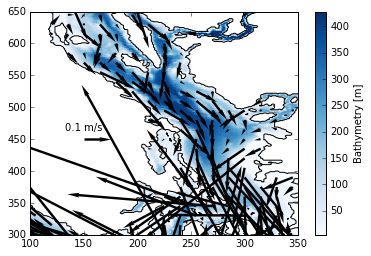

In [9]:
st=15
t=15
xx, yy = np.meshgrid(np.arange(v_depav.shape[-1]), np.arange(v_depav.shape[-2]))
fig,ax=plt.subplots(1,1)
mesh=ax.pcolormesh(bathy,cmap='Blues')
cbar=plt.colorbar(mesh,ax=ax)
cbar.set_label('Bathymetry [m]')
q=ax.quiver(xx[::st,::st],yy[::st,::st],udepav_s[t,::st,::st],vdepav_s[t,::st,::st],scale=1,
            color='k',width=0.009,headwidth=2,)
ax.quiverkey(q,150,450,.1,'0.1 m/s', color='k',coordinates='data')
ax.set_xlim([100,350])
ax.set_ylim([300,650])
viz_tools.plot_coastline(ax,grid)

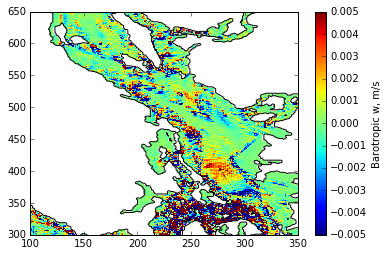

In [10]:
wB = -udepav_s*hx[1:,1:] + -vdepav_s*hy[1:,1:]
fig,ax=plt.subplots(1,1)
mesh=ax.pcolormesh(wB[t,:,:],vmin=-.005,vmax=.005)
cbar = plt.colorbar(mesh,ax=ax)
cbar.set_label('Barotropic w, m/s')
ax.set_xlim([100,350])
ax.set_ylim([300,650])
viz_tools.plot_coastline(ax,grid)

* Between Gulf islands and Tsawwassen, depth averatged currents are mostly towards the south east (ignoring bounday pass). Topoography is getting shallower so we should have upward w, which we do.
* The barotropic vertical velocity is really noisy, especially in Boundary Pass where currents are large and bathymetry is complex and steep.  This is probably mostly because the bathymetry gradients are noisy. 


# Calculating baroclinic pressure
Things needed:
* time-dependent depth levels and vertical scale factors
* conversion from depths to pressure
* depth averaging - not sure if analyze function will work because of time dependent sale factors

### ssh sdjustment factor and time dependent depths
* See NEMO vvl manul for details on this calculation.

$v^{i,j} = \sum_{k=0}^{jpk} e3t^{i,j,k,0} \sum_{n=k}^{jpk} e3t^{i,j,n,0} $
and 

$e3t^{i,j,k,t} = e3t^{i,j,k,0}\left(1 + \frac{\eta^{i,j,t}}{v^{i,j}}\sum_{n=k}^{jpk}e3t^{i,j,n,0}\right)$

Then 
* $e3w(k=0) = e3t(k=0)$
* $e3w(k>0) = \frac{1}{2} (e3t(k-1) + e3t(k))$
* $gdept(k=0) = \frac{e3t(k=0)}{2}$
* $gdept(k>0) = gdept(k-1) + e3w(k)$
* $gdepw(k=0) = 0$
* $gdepw(k>0) = \sum_{n=1}^k e3t(n-1)$

Strategy:
* Create function to calculate v
* Create an adjustment factor function that takes arugments ssh, e3t0 and v. The adjustment factor is equal to the bracketed terms in the equation.
* Create function that outputs time-dependet e3w, gdept, gdepw, e3t
* How do we figure out the u/v depths and scale factors?

In [11]:
def calculate_v(e3t0, tmask):
    """Calculate the v correction factor for variable volume in NEMO.
    e3t0 and tmask must be the same shape.
    See NEMO vvl manual appendix A.1 for details. 
    
    :arg e3t0: initial vertical scale factors on T-grid. Spatial dimensions only.
    :type e3t0: numpy array - first dimension is depth
    
    :arg tmask: T-grid mask. Spatial dimensions only.
    :type tmask: numpy array - first dimension is depth. 

    :returns: the v correction factor
              a numpy array with shape e3t0.shape[1:]
    
    """
    vn = 0
    for k in np.arange(e3t0.shape[0]):
        sum1 = 0
        for n in np.arange(k, e3t0.shape[0]):
            sum1 = sum1 + e3t0[n, ...]*tmask[n, ...]
        vn = vn +e3t0[k, :, :]*sum1*tmask[k, ...]
    return vn

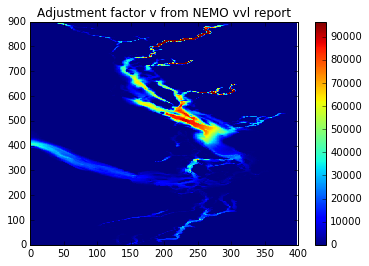

In [12]:
vn = calculate_v(e3t[0,...], tmask[0,...])
vn.shape
plt.pcolormesh(vn)
plt.colorbar()
plt.title('Adjustment factor v from NEMO vvl report')

In [13]:
def calculate_adjustment_factor(e3t_0, tmask, v, ssh):
    
    shape = list(e3t_0.shape[:])
    shape.insert(0, ssh.shape[0])
    adj = np.zeros(shape)


    for k in np.arange(e3t_0.shape[0]):
        sum1 = 0
        for n in np.arange(k,e3t_0.shape[0]):
            sum1 = sum1 + e3t_0[n, ...]*tmask[n, ...]
        adj[:, k, ...] = (1 + ssh/v*sum1)
    inds = np.where(np.isnan(adj))
    adj[inds] = 1  # Turn nans into ones
    
    return adj

In [24]:
print(tmask[0,...].shape)
adj = calculate_adjustment_factor(e3t[0,...], tmask[0,...], vn, ssh)
print(adj[0,:,400,300])

(40, 898, 398)
[ 1.03261944  1.03122092  1.0298224   1.02842386  1.0270253   1.02562671
  1.02422804  1.02282921  1.02143009  1.0200304   1.01862959  1.0172266
  1.01581937  1.01440389  1.01297233  1.01150952  1.00998597  1.00834472
  1.0064764   1.00417393  1.00105537  1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.          1.
  1.        ]


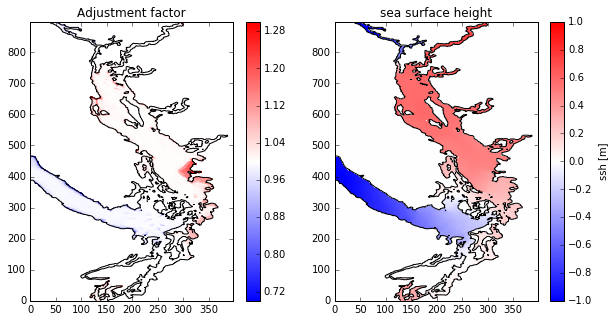

In [15]:
t=0
d=0
fig,axs=plt.subplots(1,2,figsize=(10,5))
ax=axs[0]
mesh=ax.pcolormesh(np.ma.array(adj[t,d,:,:],mask=1-tmask[0,d,:,:]),
                   vmin=.7,vmax=1.3,cmap='bwr')
plt.colorbar(mesh, ax=ax)
viz_tools.plot_coastline(ax,grid)
ax.set_title('Adjustment factor')
ax=axs[1]
mesh=plt.pcolormesh(ssh[t,:,:], vmin=-1,vmax=1,cmap='bwr')
cbar = plt.colorbar(mesh, ax=ax)
cbar.set_label('ssh [m]')
viz_tools.plot_coastline(ax,grid)
ax.set_title('sea surface height')

In [16]:
def calculate_vertical_grids(e3t_0, tmask, ssh):
    
    # adjustment factors
    vn = calculate_v(e3t_0, tmask)
    adj = calculate_adjustment_factor(e3t_0, tmask, vn, ssh)
    # scale factors
    e3t_t = e3t_0*adj
    e3w_t = np.copy(e3t_t)  # intiliaize for k=0
    e3w_t[:, 1:, ...] = 0.5*(e3t_t[:, 1:, ...] + e3t_t[:, 0:-1, ...])  # overwrite k>0   
    # depths
    gdept_t = 0.5*e3t_t  # initialize for k=0
    for k in np.arange(1,gdept_t.shape[1]):
        gdept_t[:, k, ...] = gdept_t[:, k-1, ...] + e3w_t[:, k, ...] # overwrite k>0
    gdepw_t = np.zeros(gdept_t.shape)  # initialize for k=0
    gdepw_t[:, 1:, ...] = np.cumsum(e3t_t[:, 0:-1, ...], axis=1)
    
    return e3t_t, e3w_t, gdept_t, gdepw_t 

In [17]:
e3t_t, e3w_t, gdept_t, gdepw_t = calculate_vertical_grids(e3t[0,...], tmask[0,...], ssh)

In [18]:
gdept_t[0,:,400,300]

array([   0.51631032,    1.54823368,    2.57876437,    3.60790793,
          4.63567509,    5.66208675,    6.68718356,    7.71104458,
          8.73382359,    9.75581967,   10.77761448,   11.80033913,
         12.82619266,   13.85944853,   14.90840452,   15.98914619,
         17.13275746,   18.39893766,   19.9009913 ,   21.84911162,
         23.34643151,   24.10146277,   28.46603683,   38.36594296,
         52.33255179,   70.36586329,   91.75183086,  115.47881313,
        140.65083651,  166.64591883,  193.08798807,  219.76645908,
        246.56819427,  273.43372386,  300.33214196,  327.24748146,
        354.17151818,  381.1000227 ,  408.03082173,  434.96279897])

In [19]:
e3t_t[0,:,400,300]

array([  1.03262063,   1.03122609,   1.0298353 ,   1.02845181,
         1.02708251,   1.02574081,   1.02445281,   1.02326924,
         1.02228878,   1.02170338,   1.02188625,   1.02356305,
         1.02814401,   1.03836773,   1.05954425,   1.10193908,
         1.18528346,   1.34707695,   1.65703034,   2.2392103 ,
         0.75542947,   0.75463306,   7.97451506,  11.8252972 ,
        16.10792044,  19.95870258,  22.81323256,  24.64073198,
        25.70331479,  26.28684983,  26.59728865,  26.75965336,
        26.84381704,  26.88724213,  26.90959407,  26.92108493,
        26.9269885 ,  26.93002054,  26.93157752,  26.93237697])

In [27]:
print(e3t[0,:,400,300])

[  1.00000115   1.00000501   1.00001253   1.00002718   1.0000557
   1.00011125   1.00021946   1.0004302    1.00084067   1.00164012
   1.0031971    1.00622914   1.01213271   1.02362358   1.04597551
   1.08940061   1.17356428   1.33592899   1.64636781   2.22990285
   0.75463306   0.75463306   7.97451506  11.8252972   16.10792044
  19.95870258  22.81323256  24.64073198  25.70331479  26.28684983
  26.59728865  26.75965336  26.84381704  26.88724213  26.90959407
  26.92108493  26.9269885   26.93002054  26.93157752  26.93237697]


In [20]:
e3w_t[0,:,400,300]

array([  1.03262063,   1.03192336,   1.0305307 ,   1.02914356,
         1.02776716,   1.02641166,   1.02509681,   1.02386102,
         1.02277901,   1.02199608,   1.02179481,   1.02272465,
         1.02585353,   1.03325587,   1.04895599,   1.08074166,
         1.14361127,   1.2661802 ,   1.50205364,   1.94812032,
         1.49731988,   0.75503126,   4.36457406,   9.89990613,
        13.96660882,  18.03331151,  21.38596757,  23.72698227,
        25.17202338,  25.99508231,  26.44206924,  26.67847101,
        26.8017352 ,  26.86552958,  26.8984181 ,  26.9153395 ,
        26.92403672,  26.92850452,  26.93079903,  26.93197724])

In [21]:
gdepw_t[0,:,400,300]

array([   0.        ,    1.03262063,    2.06384672,    3.09368202,
          4.12213383,    5.14921634,    6.17495715,    7.19940996,
          8.2226792 ,    9.24496798,   10.26667136,   11.28855761,
         12.31212066,   13.34026467,   14.3786324 ,   15.43817665,
         16.54011573,   17.72539919,   19.07247613,   20.72950647,
         22.96871677,   23.72414624,   24.4787793 ,   32.45329436,
         44.27859157,   60.386512  ,   80.34521458,  103.15844714,
        127.79917912,  153.50249391,  179.78934374,  206.38663239,
        233.14628576,  259.99010279,  286.87734493,  313.78693899,
        340.70802393,  367.63501243,  394.56503297,  421.49661049])

In [22]:
ssh[0,400,300]

0.39984733

In [23]:
gdept_0 = mesh_mask.variables['gdept'][:]
(gdept_0[0,:,400,300] - gdept_t[0,:,400,300])*tmask[0,:,400,300]

array([-0.01631002, -0.04823058, -0.07875293, -0.10787741, -0.13560452,
       -0.16193607, -0.18687314, -0.21042136, -0.23258763, -0.25338685,
       -0.27284897, -0.29102746, -0.30802612, -0.3240367 , -0.3394224 ,
       -0.35485835, -0.37158421, -0.39180227, -0.41920648, -0.45913321,
       -0.39250542, -0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

In [28]:
print(gdept_0[0,:,400,300])

[   0.5000003     1.5000031     2.50001144    3.50003052    4.50007057
    5.50015068    6.50031042    7.50062323    8.50123596    9.50243282
   10.50476551   11.50931168   12.51816654   13.53541183   14.56898212
   15.63428783   16.76117325   18.00713539   19.48178482   21.38997841
   22.95392609   23.70855904   34.68575668   44.51772308   58.48433304
   76.58558655   98.06295776  121.86651611  147.08946228  173.11448669
  199.57304382  226.26029968  253.06663513  279.93453979  306.834198
  333.75018311  360.67453003  387.60321045  414.53408813  441.46609497]


In [31]:
gdepw_0 = mesh_mask.variables['gdepw'][:]
print(gdepw_0[0,:,400,300]*tmask[0,:,400,300])

[  0.           1.00000119   2.00000644   3.00001931   4.00004673
   5.00010395   6.00021696   7.0004406    8.00087929   9.00173569
  10.00340652  11.00666237  12.01300812  13.02536583  14.04942894
  15.0962553   16.18730354  17.36403465  18.70597267  20.36347389
  22.61306381   0.           0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.           0.        ]
